# Leaf Segmentation Pypeline
- Imports
- Crop images
- Identify contour
- Overlay images
- Crop the stem
- Identify damages
- Compute areas and ratios
- Define conversion rate
- Export results to excel file 

# Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Read Images

In [49]:
id = 4411

In [50]:
image = cv2.imread(f'images/IMG_{id}.JPG')
image.shape

(5184, 3888, 3)

# Crop Images

In [51]:
height, width, _ = image.shape

y, h = 0, 3050  # upper starting point, lower ending point
x, w = 800, 2250  # lefter starting point, righter ending point

crop_img = image[y:y+h, x:x+w]

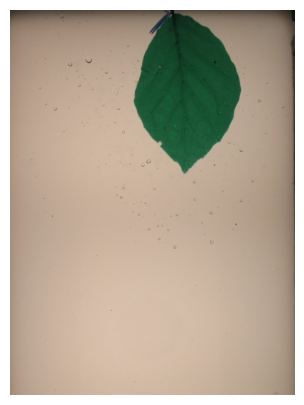

In [52]:
plt.figure(figsize=(5, 5))
plt.imshow(crop_img)
plt.axis('off')
plt.show()

In [53]:
image = crop_img

# Identify Contour

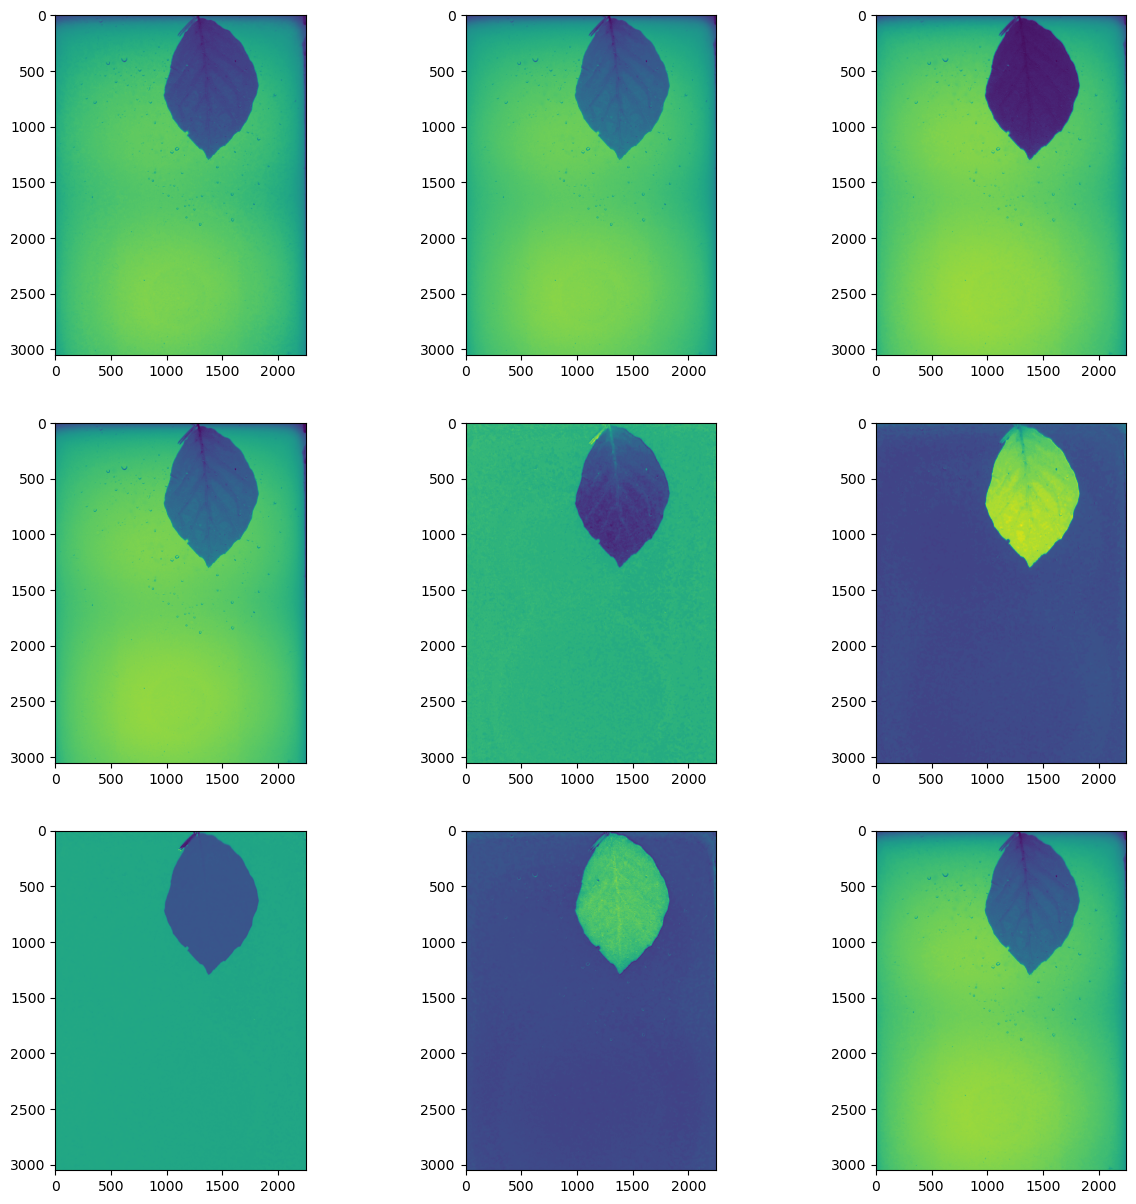

In [54]:
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# RGB Channel
R = img_rgb[:, :, 0]
G = img_rgb[:, :, 1]
B = img_rgb[:, :, 2]

# LAB Channel
L = img_lab[:, :, 0]
a = img_lab[:, :, 1]
b = img_lab[:, :, 2]

# HSV Channel
H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# RGB Images
ax[0][0].imshow(R)
ax[0][1].imshow(G)
ax[0][2].imshow(B)

# LAB Images
ax[1][0].imshow(L)
ax[1][1].imshow(a)
ax[1][2].imshow(b)

# HSV Images
ax[2][0].imshow(H)
ax[2][1].imshow(S)
ax[2][2].imshow(V)

plt.show()

# Improve segmentation here!
# Need to remove the viola thing above.

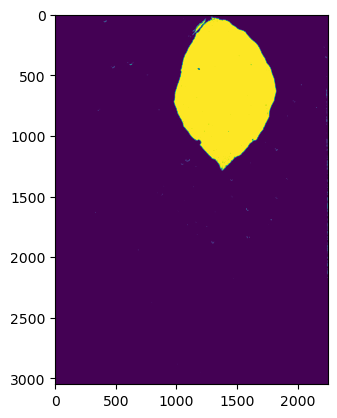

CPU times: user 4.4 s, sys: 171 ms, total: 4.57 s
Wall time: 1.65 s


In [73]:
%%time

criteria = S  # or H!!

pixel_vals = criteria.flatten()
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
K = 2
retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((criteria.shape))
pixel_labels = labels.reshape(img_hsv.shape[0], img_hsv.shape[1])
plt.imshow(segmented_image)
plt.show()

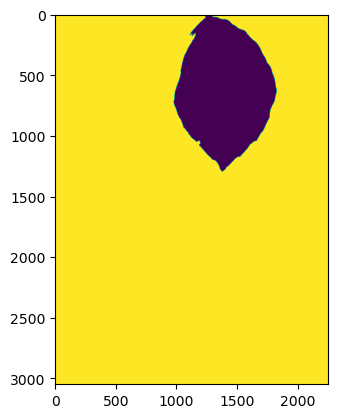

CPU times: user 573 ms, sys: 154 ms, total: 727 ms
Wall time: 270 ms


In [72]:
""" 
# Puts everything together
%%time
# Label connected components in the image
pixel_labels = np.uint8(pixel_labels)
ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)

# Determine the size of each component (number of pixels)
sizes = np.bincount(components.ravel())
# Set the minimum size threshold to 0 initially (will be updated to the size of the largest component)
max_size = 0
for size in sizes:
    if size > max_size:
        max_size = size

# Create a new mask where only the largest component is set to 1
mask_largest = np.zeros_like(components)
mask_largest[components == np.argmax(sizes)] = 1

plt.imshow(mask_largest)
plt.show()
"""

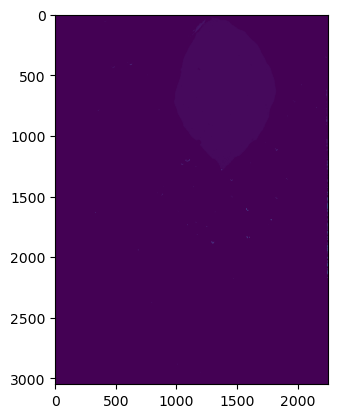

CPU times: user 534 ms, sys: 142 ms, total: 676 ms
Wall time: 244 ms


In [74]:
%%time
# Doing this, some unwanted pixels that are clustered in main cluster can be avoided.
# Ref - https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gac2718a64ade63475425558aa669a943a
pixel_labels = np.uint8(pixel_labels)
ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)
plt.imshow(components)
plt.show()

In [75]:
%%time

indices = []
for i in range(1, ret):
    row, col = np.where(components==i)
    indices.append(max(len(row), len(col)))
component = np.argmax(np.array(indices))
main_component = component+1   #indexing starts from 0, so we increment by 1 to get actual component index

# Creating a mask and extracting pixels corresponding to cluster to which leaf belongs.
# In this case, we want 0 for actual leaf pixels and 1 for other pixels.
# The np.where statement is therefore inverted compared to the previous version.
mask = np.where(components==main_component, 0, 1)

B = image[:, :, 0]
G = image[:, :, 1]
R = image[:, :, 2]

# Convert mask to same dtype as image
mask = mask.astype(B.dtype)

# Extract only masked pixels
r = R*mask
g = G*mask
b = B*mask

final_img = np.dstack((b, g, r))

# Convert final_img to RGB format for display
final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

CPU times: user 3.98 s, sys: 16.4 ms, total: 4 s
Wall time: 4 s


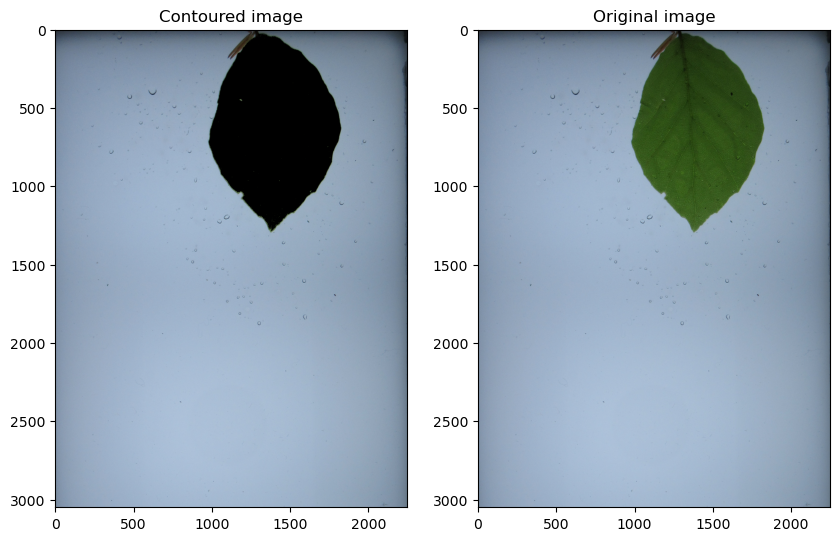

In [76]:
# Display images
fig, ax = plt.subplots(1, 2, figsize=(10, 15))

ax[0].imshow(final_img_rgb)
ax[0].set_title('Contoured image')

ax[1].imshow(img_rgb)
ax[1].set_title('Original image')
plt.show()

In [60]:
import cv2
import matplotlib.pyplot as plt

# Assume 'final_img' is your input image
final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(final_img_rgb, cv2.COLOR_RGB2GRAY)

# Apply a threshold
_, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Apply median blur
final = cv2.medianBlur(binary, 59)

# Convert the binary image to a boolean mask
mask = final.astype(bool)

# Create a blank RGB image filled with zeros
rgb_masked = np.zeros_like(final_img_rgb)

rgb_binary = np.zeros_like(final_img_rgb)

# Apply the mask to each channel of the RGB image
for i in range(3):
    rgb_masked[:,:,i] = final_img_rgb[:,:,i]*mask
    rgb_binary[:,:,i] = mask*255

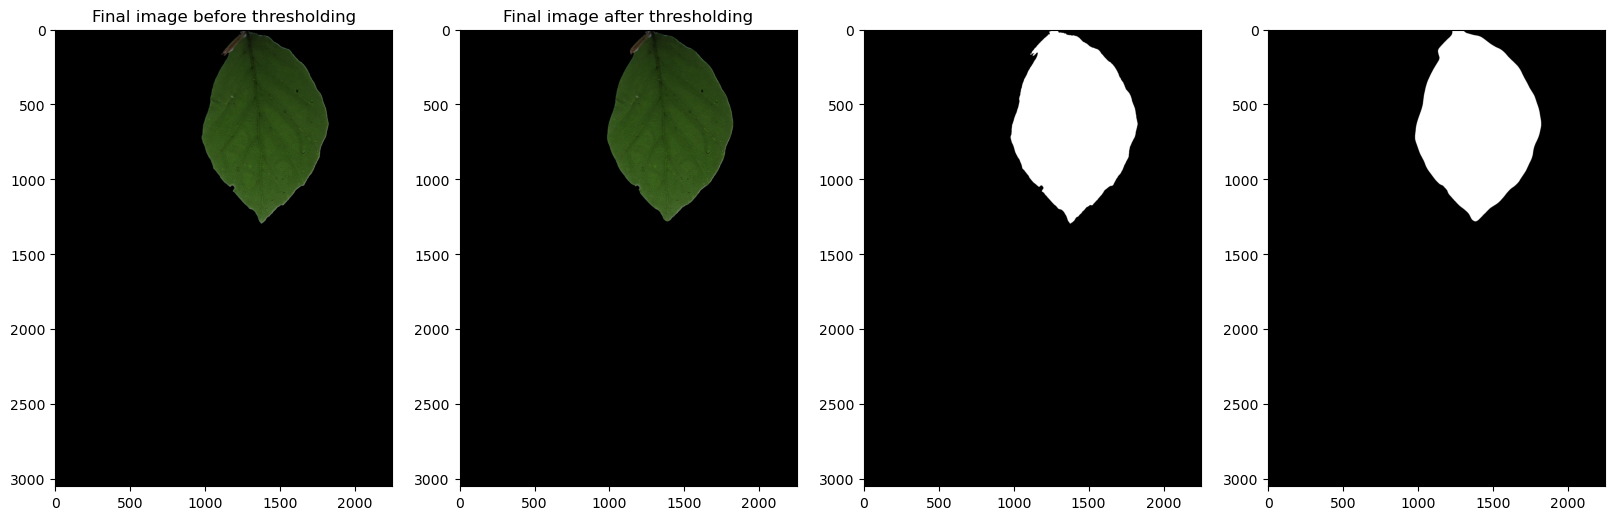

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

ax[0].imshow(final_img_rgb)
ax[0].set_title("Final image before thresholding")



ax[1].imshow(rgb_masked, cmap='gray')
ax[1].set_title("Final image after thresholding")

ax[2].imshow(binary, cmap='gray')
ax[3].imshow(rgb_binary, cmap='gray')

plt.show()

# Find Holes

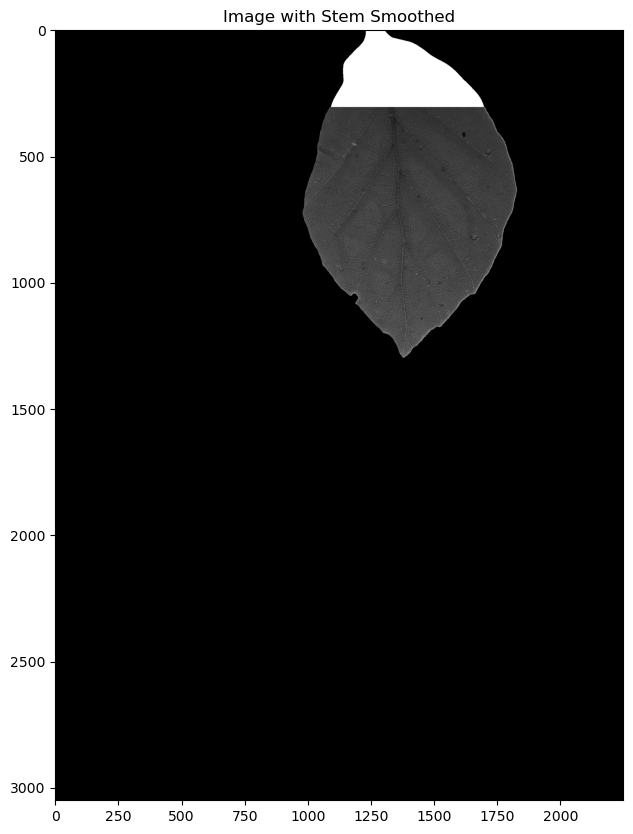

In [62]:
# Assume 'final_img' is your input image
final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(final_img_rgb, cv2.COLOR_RGB2GRAY)

# Define your stem region (top part of the image)
stem_portion = 0.1  # Adjust this value as needed
end = int(stem_portion*gray.shape[0])

# Separate the leaf and stem parts
stem_region = gray[:end,:]
leaf_region = gray[end:,:]

# Apply a threshold and median blur to the stem region
_, binary_stem = cv2.threshold(stem_region, 1, 255, cv2.THRESH_BINARY)
final_stem = cv2.medianBlur(binary_stem, 77)

# Reconstruct the image
gray_new = np.concatenate((final_stem, leaf_region), axis=0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(gray_new, cmap='gray')
plt.title('Image with Stem Smoothed')
plt.show()

In [66]:
# Create masks for the original and smoothed images
_, mask_stem = cv2.threshold(final_stem, 1, 255, cv2.THRESH_BINARY)
_, mask_leaf = cv2.threshold(leaf_region, 1, 255, cv2.THRESH_BINARY)

# Combine the masks
mask_combined = np.concatenate((mask_stem, mask_leaf), axis=0)

# Convert the binary mask to a boolean mask
mask_combined_bool = mask_combined.astype(bool)

# Create a 3-channel version of the mask by repeating the same mask on each channel
mask_color = np.dstack((mask_combined_bool, mask_combined_bool, mask_combined_bool))

# Use the mask to extract the leaf from the original image
final_img_masked = np.where(mask_color, final_img_rgb, 0)

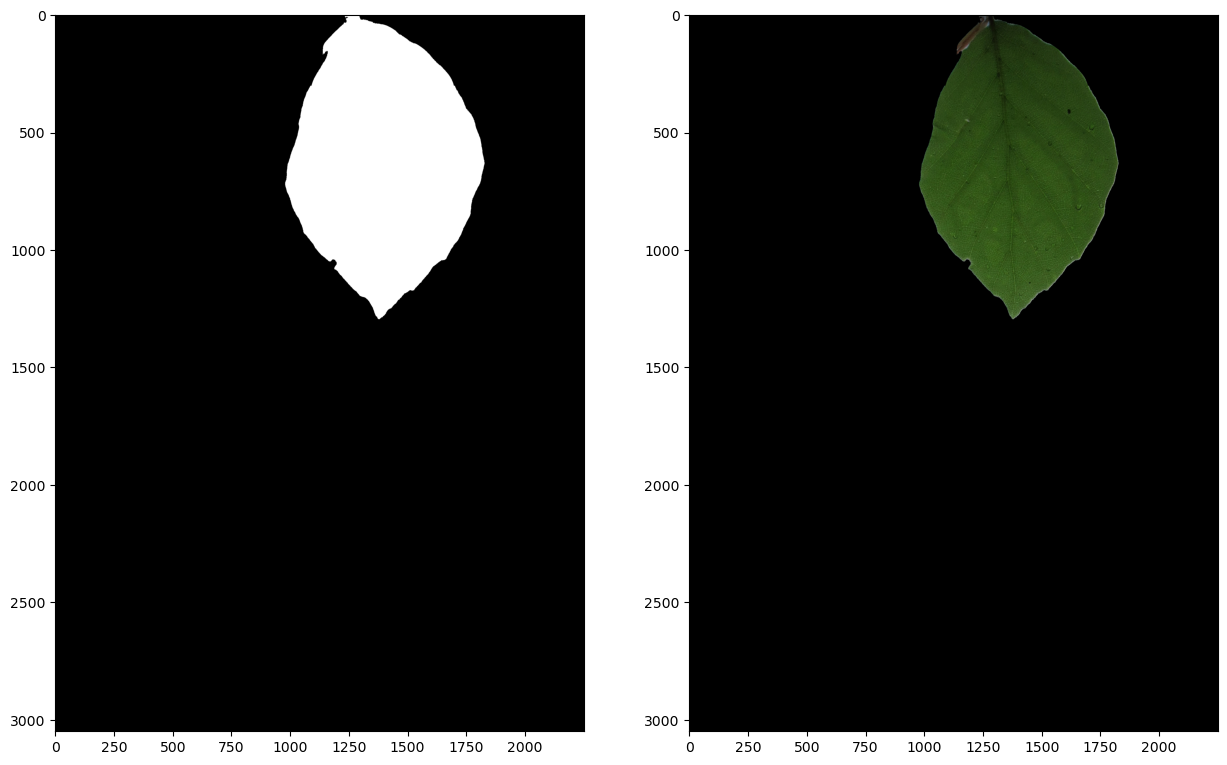

In [70]:
import cv2

# Assuming 'final_img_masked' is the masked image from the previous steps

# Convert the image to grayscale
final_gray = cv2.cvtColor(final_img_masked, cv2.COLOR_RGB2GRAY)

# Convert the grayscale image to binary
_, binary = cv2.threshold(final_gray, 1, 255, cv2.THRESH_BINARY)

# Find connected components
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# The first component is the background, so we will neglect the first component
max_area = 0
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] > max_area:
        max_area = stats[i, cv2.CC_STAT_AREA]
        max_label = i

# Create a new binary image with only the largest component
largest_component_image = np.zeros(labels_im.shape, dtype=np.uint8)
largest_component_image[labels_im == max_label] = 255

# Convert the largest component image to a binary mask
mask = largest_component_image.astype(bool)

# Create a copy of the original image to overlay the mask
final_img_masked = final_img_rgb.copy()

# Apply the mask to the original image using bitwise operations
final_img_masked[~mask] = 0

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(largest_component_image, cmap='gray')
ax[1].imshow(final_img_masked)

plt.show()